In [1]:
#!wget http://imagenet.stanford.edu/internal/car196/bmw10_release.tgz

In [2]:
#!tar -xvf bmw10_release.tgz

In [3]:
#!rm -r outputs

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms 

In [5]:
kernel_size = 4
stride = 1
padding = 0
init_kernel = 16 # initial number of filters

In [6]:
# define a Conv VAE
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=3, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_kernel, out_channels=init_kernel*2, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_kernel*2, out_channels=init_kernel*4, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_kernel*4, out_channels=init_kernel*8, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc5 = nn.Conv2d(
            in_channels=init_kernel*8, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )

        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=init_kernel, out_channels=init_kernel*8, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_kernel*8, out_channels=init_kernel*4, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_kernel*4, out_channels=init_kernel*2, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_kernel*2, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec5 = nn.ConvTranspose2d(
            in_channels=init_kernel, out_channels=3, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
 
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = self.enc5(x)

        # get `mu` and `log_var`
        mu = x
        log_var = x

        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
 
        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        reconstruction = torch.sigmoid(self.dec5(x))
        return reconstruction, mu, log_var

In [7]:
import scipy.io
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchvision.utils import save_image

In [8]:
# learning parameters
batch_size = 64
lr = 0.001
epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
transform=transforms.Compose([
                    transforms.Resize(64),
                    transforms.CenterCrop(64),
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                    ])

In [10]:
train_dataset=torchvision.datasets.ImageFolder(root='/content/bmw10_ims', transform=transform)
test_dataset=torchvision.datasets.ImageFolder(root='/content/test', transform=transform)

In [11]:
# divide the data into train and validation set
print(f"Training instances: {len(train_dataset)}")
print(f"Validation instances: {len(test_dataset)}")

Training instances: 512
Validation instances: 50


In [12]:
# iterable data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(test_dataset, batch_size=batch_size)

In [13]:
model = ConvVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

In [14]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [15]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, (data,label) in tqdm(enumerate(dataloader), total=int(len(train_dataset)/dataloader.batch_size)):
        data= data
        data = data.to(device)
        data = data
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()

    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [16]:
GImages=[]
OImages=[]
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, (data,label) in tqdm(enumerate(dataloader), total=int(len(test_dataset)/dataloader.batch_size)):
            data= data
            data = data.to(device)
            data = data
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            #if i == batch_size-1:
            num_rows = 32
            both = torch.cat((data[:32], reconstruction[:32]))
            save_image(both.cpu(), f"/content/outputs/output{epoch}.png", nrow=num_rows)
            GImages.append(reconstruction[:32])
            OImages.append(data[:32])
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [17]:
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, val_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1 of 100


100%|██████████| 8/8 [00:05<00:00,  1.46it/s]
1it [00:00,  2.12it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: 966.9594
Val Loss: -57343.5050
Epoch 2 of 100


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]
1it [00:00,  2.24it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -218111.5840
Val Loss: -321932.0800
Epoch 3 of 100


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]
1it [00:00,  2.25it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -358770.8594
Val Loss: -346978.7200
Epoch 4 of 100


100%|██████████| 8/8 [00:05<00:00,  1.48it/s]
1it [00:00,  2.22it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -358320.8594
Val Loss: -411211.8400
Epoch 5 of 100


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]
1it [00:00,  2.17it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -401659.4805
Val Loss: -421718.8800
Epoch 6 of 100


100%|██████████| 8/8 [00:05<00:00,  1.48it/s]
1it [00:00,  2.30it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -411666.3477
Val Loss: -433033.0400
Epoch 7 of 100


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]
1it [00:00,  2.28it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -422347.4922
Val Loss: -436428.8400
Epoch 8 of 100


100%|██████████| 8/8 [00:05<00:00,  1.45it/s]
1it [00:00,  2.27it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -431188.1836
Val Loss: -445655.0000
Epoch 9 of 100


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]
1it [00:00,  2.22it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -439244.2227
Val Loss: -452294.5600
Epoch 10 of 100


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]
1it [00:00,  2.29it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -446568.2227
Val Loss: -460514.2000
Epoch 11 of 100


100%|██████████| 8/8 [00:05<00:00,  1.48it/s]
1it [00:00,  2.28it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -450737.0781
Val Loss: -470211.6000
Epoch 12 of 100


100%|██████████| 8/8 [00:05<00:00,  1.48it/s]
1it [00:00,  2.22it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -457290.1289
Val Loss: -475432.4400
Epoch 13 of 100


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]
1it [00:00,  2.25it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -461870.0156
Val Loss: -481751.0800
Epoch 14 of 100


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]
1it [00:00,  2.25it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -467638.0352
Val Loss: -485727.9600
Epoch 15 of 100


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]
1it [00:00,  2.28it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -478429.1914
Val Loss: -528150.2800
Epoch 16 of 100


100%|██████████| 8/8 [00:05<00:00,  1.48it/s]
1it [00:00,  2.23it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -523859.2070
Val Loss: -533920.7600
Epoch 17 of 100


100%|██████████| 8/8 [00:05<00:00,  1.48it/s]
1it [00:00,  2.25it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -530383.6250
Val Loss: -555326.1600
Epoch 18 of 100


100%|██████████| 8/8 [00:05<00:00,  1.45it/s]
1it [00:00,  2.18it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -545840.9570
Val Loss: -554631.4400
Epoch 19 of 100


100%|██████████| 8/8 [00:05<00:00,  1.45it/s]
1it [00:00,  2.16it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -555343.6641
Val Loss: -568146.5600
Epoch 20 of 100


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]
1it [00:00,  2.26it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -562846.7227
Val Loss: -575261.2800
Epoch 21 of 100


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]
1it [00:00,  2.27it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -568914.3672
Val Loss: -575214.8400
Epoch 22 of 100


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]
1it [00:00,  2.28it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -573107.7266
Val Loss: -585026.8000
Epoch 23 of 100


100%|██████████| 8/8 [00:05<00:00,  1.48it/s]
1it [00:00,  2.27it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -579787.4609
Val Loss: -587498.4800
Epoch 24 of 100


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]
1it [00:00,  2.25it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -586896.5391
Val Loss: -598309.3600
Epoch 25 of 100


100%|██████████| 8/8 [00:05<00:00,  1.48it/s]
1it [00:00,  2.26it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -595351.8359
Val Loss: -606303.6800
Epoch 26 of 100


100%|██████████| 8/8 [00:05<00:00,  1.46it/s]
1it [00:00,  2.26it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -603468.6172
Val Loss: -624343.4400
Epoch 27 of 100


100%|██████████| 8/8 [00:05<00:00,  1.44it/s]
1it [00:00,  2.29it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -613861.4219
Val Loss: -617847.0800
Epoch 28 of 100


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]
1it [00:00,  2.23it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -617586.1875
Val Loss: -635686.9200
Epoch 29 of 100


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]
1it [00:00,  2.24it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -626601.0469
Val Loss: -638907.0000
Epoch 30 of 100


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]
1it [00:00,  2.27it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -630604.9375
Val Loss: -648193.2800
Epoch 31 of 100


100%|██████████| 8/8 [00:05<00:00,  1.48it/s]
1it [00:00,  2.28it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -636669.1953
Val Loss: -646742.7200
Epoch 32 of 100


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]
1it [00:00,  2.25it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -643023.8984
Val Loss: -656576.0800
Epoch 33 of 100


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]
1it [00:00,  2.22it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -646870.1953
Val Loss: -653085.3200
Epoch 34 of 100


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]
1it [00:00,  2.30it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -649575.4688
Val Loss: -657228.7600
Epoch 35 of 100


100%|██████████| 8/8 [00:05<00:00,  1.48it/s]
1it [00:00,  2.27it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -651689.9141
Val Loss: -669221.2000
Epoch 36 of 100


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]
1it [00:00,  2.32it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -655115.2344
Val Loss: -668948.8400
Epoch 37 of 100


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]
1it [00:00,  2.32it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -655913.5469
Val Loss: -666447.0800
Epoch 38 of 100


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]
1it [00:00,  2.28it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -658210.1016
Val Loss: -662688.6400
Epoch 39 of 100


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]
1it [00:00,  2.31it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -660479.0234
Val Loss: -671122.8000
Epoch 40 of 100


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]
1it [00:00,  2.27it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -662403.2109
Val Loss: -667472.0400
Epoch 41 of 100


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]
1it [00:00,  2.32it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -664361.4766
Val Loss: -675882.0800
Epoch 42 of 100


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]
1it [00:00,  2.31it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -666682.8125
Val Loss: -677862.7200
Epoch 43 of 100


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]
1it [00:00,  2.30it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -668170.9531
Val Loss: -678836.2400
Epoch 44 of 100


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]
1it [00:00,  2.29it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -670489.9688
Val Loss: -678342.9600
Epoch 45 of 100


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
1it [00:00,  2.30it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -672895.3516
Val Loss: -687163.7600
Epoch 46 of 100


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]
1it [00:00,  2.30it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -674457.4688
Val Loss: -688313.5200
Epoch 47 of 100


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
1it [00:00,  2.27it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -675909.7969
Val Loss: -692287.4400
Epoch 48 of 100


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]
1it [00:00,  2.34it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -676990.1797
Val Loss: -693923.6800
Epoch 49 of 100


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]
1it [00:00,  2.29it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -679633.3203
Val Loss: -682212.1600
Epoch 50 of 100


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]
1it [00:00,  2.34it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -681005.1094
Val Loss: -699878.2400
Epoch 51 of 100


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]
1it [00:00,  2.32it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -682302.9609
Val Loss: -696215.9200
Epoch 52 of 100


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
1it [00:00,  2.27it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -684795.6250
Val Loss: -696031.6800
Epoch 53 of 100


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]
1it [00:00,  2.29it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -685350.7578
Val Loss: -696031.6800
Epoch 54 of 100


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]
1it [00:00,  2.29it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -685656.0000
Val Loss: -694074.4800
Epoch 55 of 100


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]
1it [00:00,  2.31it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -686584.7578
Val Loss: -700292.2400
Epoch 56 of 100


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
1it [00:00,  2.19it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -688663.8906
Val Loss: -696674.4800
Epoch 57 of 100


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]
1it [00:00,  2.30it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -687832.2031
Val Loss: -700070.6400
Epoch 58 of 100


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
1it [00:00,  2.32it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -689724.4062
Val Loss: -698189.8400
Epoch 59 of 100


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
1it [00:00,  2.29it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -689785.0000
Val Loss: -703426.4800
Epoch 60 of 100


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
1it [00:00,  2.24it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -690939.8984
Val Loss: -706231.8400
Epoch 61 of 100


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
1it [00:00,  2.30it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -691749.8281
Val Loss: -706796.2400
Epoch 62 of 100


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]
1it [00:00,  2.27it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -692114.5859
Val Loss: -708695.1200
Epoch 63 of 100


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
1it [00:00,  2.35it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -691292.5078
Val Loss: -698165.8400
Epoch 64 of 100


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]
1it [00:00,  2.34it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -690671.9609
Val Loss: -710865.9200
Epoch 65 of 100


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]
1it [00:00,  2.25it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -695108.2031
Val Loss: -712047.2000
Epoch 66 of 100


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
1it [00:00,  2.24it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -695080.5625
Val Loss: -703599.3600
Epoch 67 of 100


100%|██████████| 8/8 [00:05<00:00,  1.46it/s]
1it [00:00,  2.24it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -696622.1250
Val Loss: -708794.1600
Epoch 68 of 100


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]
1it [00:00,  2.26it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -696432.3359
Val Loss: -707434.4800
Epoch 69 of 100


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]
1it [00:00,  2.31it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -695629.6094
Val Loss: -711228.6400
Epoch 70 of 100


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
1it [00:00,  2.29it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -697209.7578
Val Loss: -710325.2000
Epoch 71 of 100


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
1it [00:00,  2.28it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -697978.9453
Val Loss: -710183.7600
Epoch 72 of 100


100%|██████████| 8/8 [00:05<00:00,  1.48it/s]
1it [00:00,  2.25it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -696392.8125
Val Loss: -715730.6400
Epoch 73 of 100


100%|██████████| 8/8 [00:05<00:00,  1.46it/s]
1it [00:00,  2.34it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -697325.3906
Val Loss: -714839.7600
Epoch 74 of 100


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]
1it [00:00,  2.32it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -698537.4375
Val Loss: -702223.5200
Epoch 75 of 100


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]
1it [00:00,  2.25it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -698563.3750
Val Loss: -712753.2800
Epoch 76 of 100


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
1it [00:00,  2.29it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -698724.1016
Val Loss: -713896.2400
Epoch 77 of 100


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]
1it [00:00,  2.28it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -698881.2500
Val Loss: -714432.9600
Epoch 78 of 100


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]
1it [00:00,  2.29it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -698948.2969
Val Loss: -712025.4400
Epoch 79 of 100


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
1it [00:00,  2.32it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -699759.7109
Val Loss: -698299.8400
Epoch 80 of 100


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]
1it [00:00,  2.30it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -698021.6562
Val Loss: -706821.8400
Epoch 81 of 100


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]
1it [00:00,  2.26it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -699547.9453
Val Loss: -708656.1600
Epoch 82 of 100


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]
1it [00:00,  2.28it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -699100.6875
Val Loss: -713115.8400
Epoch 83 of 100


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
1it [00:00,  2.30it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -698141.6484
Val Loss: -718972.4800
Epoch 84 of 100


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
1it [00:00,  2.30it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -701103.9766
Val Loss: -713045.3600
Epoch 85 of 100


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
1it [00:00,  2.31it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -701097.4531
Val Loss: -722374.6400
Epoch 86 of 100


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
1it [00:00,  2.32it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -702386.1094
Val Loss: -714769.9200
Epoch 87 of 100


100%|██████████| 8/8 [00:05<00:00,  1.48it/s]
1it [00:00,  2.28it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -702032.2422
Val Loss: -719052.9600
Epoch 88 of 100


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]
1it [00:00,  2.29it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -702650.4688
Val Loss: -722218.8000
Epoch 89 of 100


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
1it [00:00,  2.32it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -702769.9922
Val Loss: -722902.8800
Epoch 90 of 100


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
1it [00:00,  2.26it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -703791.3984
Val Loss: -716804.6400
Epoch 91 of 100


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]
1it [00:00,  2.23it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -704574.9531
Val Loss: -716161.2800
Epoch 92 of 100


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
1it [00:00,  2.32it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -703242.8047
Val Loss: -724827.2000
Epoch 93 of 100


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]
1it [00:00,  2.20it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -704068.6719
Val Loss: -712449.1200
Epoch 94 of 100


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
1it [00:00,  2.30it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -703256.7344
Val Loss: -720472.1600
Epoch 95 of 100


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]
1it [00:00,  2.28it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -704301.2109
Val Loss: -720877.1200
Epoch 96 of 100


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]
1it [00:00,  2.28it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -704225.7891
Val Loss: -722760.4800
Epoch 97 of 100


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
1it [00:00,  2.31it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -706350.4531
Val Loss: -715013.2000
Epoch 98 of 100


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
1it [00:00,  2.19it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -705415.6719
Val Loss: -722451.7600
Epoch 99 of 100


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]
1it [00:00,  2.27it/s]
  0%|          | 0/8 [00:00<?, ?it/s]

Train Loss: -706287.0312
Val Loss: -716634.4000
Epoch 100 of 100


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]
1it [00:00,  2.25it/s]

Train Loss: -705459.4297
Val Loss: -722461.6800


In [ ]:
!zip -r /content/result.zip /content/outputs

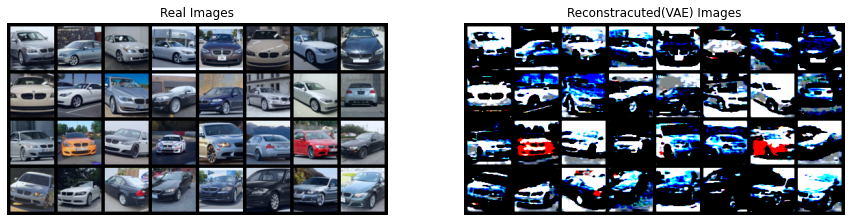

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# Grab a batch of real images from the dataloader

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(OImages[-1].to(device)[:32], padding=5, normalize=True).cpu(),(1,2,0)))
#plt.imshow(np.transpose(OImages[-1].cpu()[0],(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Reconstracuted(VAE) Images")
plt.imshow(np.transpose(vutils.make_grid(GImages[-1].to(device)[:32], padding=5, normalize=True).cpu(),(1,2,0)))
#plt.imshow(np.transpose(GImages[-1].cpu()[0],(1,2,0)))
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


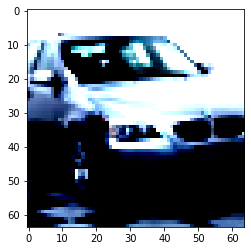

In [39]:
plt.imshow(np.transpose(OImages[-1].cpu()[0], (1,2,0)))